In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import sklearn

plt.style.use('seaborn')

Matplotlib is building the font cache; this may take a moment.


# Datos en las columnas
# ------------------------------
Edad (discreta), Sexo (categorica), Tipo de dolor de pecho (4 posibles dolores, categorica), Presion sanguinea (continua),
Colesterol (mg/dl) (continua), azucar en sangre mayor a 120mg/dl (categorica), resultado electrocardiograma (categorica), frecuencia cardiaca maxima (continua), angina inducida por ejercicio (categorica), st depression ? (continua), slope (categorica), radioscopia (categorica), thal (categorica 3 valores), enfermedad del corazon (categorica - target -> modelo de clasificacion)

In [2]:
# carga csv

heart_csv = pd.read_csv("heart.csv")
heart_csv.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
heart_csv['target'] = heart_csv['target'].astype('category')
heart_csv['sex'] = heart_csv['sex'].astype('category')
heart_csv['cp'] = heart_csv['cp'].astype('category')
heart_csv['fbs'] = heart_csv['fbs'].astype('category')
heart_csv['restecg'] = heart_csv['restecg'].astype('category')
heart_csv['fbs'] = heart_csv['fbs'].astype('category')
heart_csv['exang'] = heart_csv['exang'].astype('category')
heart_csv['slope'] = heart_csv['slope'].astype('category')
heart_csv['ca'] = heart_csv['ca'].astype('category')
heart_csv['thal'] = heart_csv['thal'].astype('category')
heart_csv['target'] = heart_csv['target'].astype('int64')

heart_csv.dtypes

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca          category
thal        category
target         int64
dtype: object

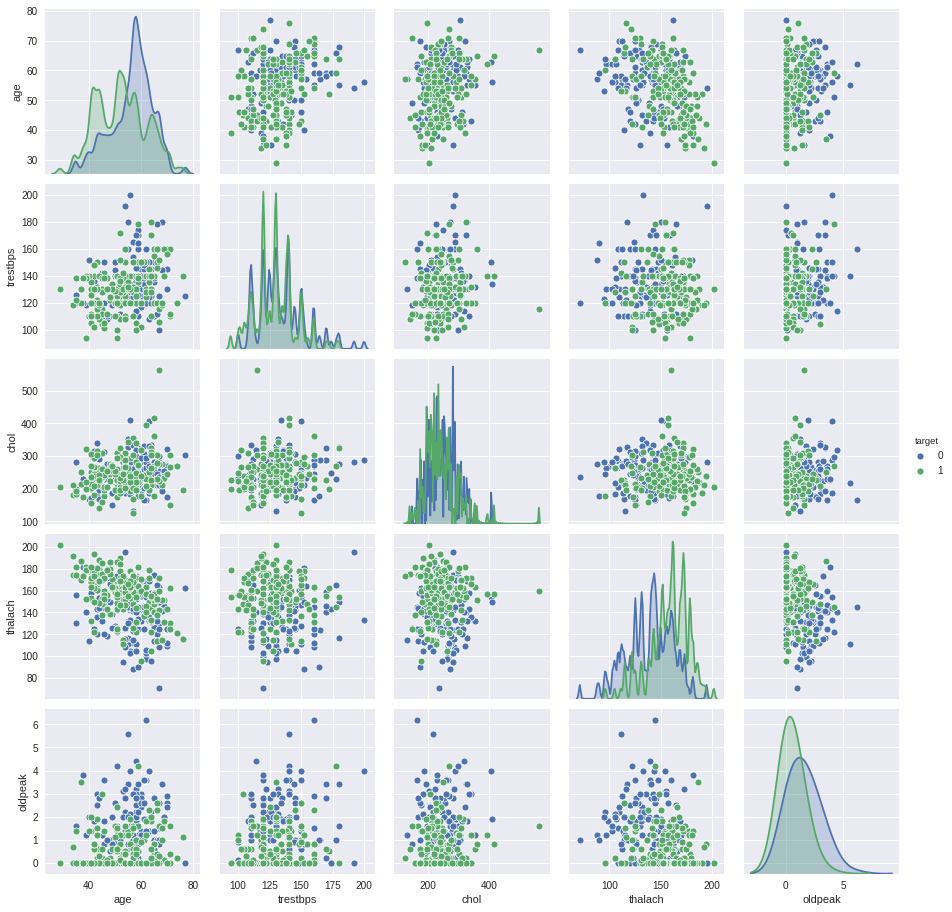

In [257]:
# pairplot de las variables mas llamativas
sns.pairplot(heart_csv, vars=['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], hue='target', diag_kws={'bw': 1})

<AxesSubplot:xlabel='fbs', ylabel='count'>

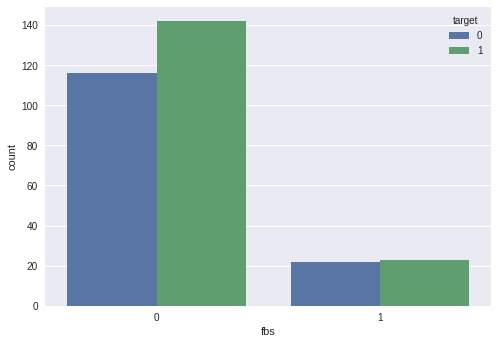

In [58]:
sns.countplot(x="fbs", hue='target', data=heart_csv)

In [ ]:
# violin plots 

fig, axs = plt.subplots(ncols=2, nrows=7, figsize=(16, 16), sharex='row')
ax = iter(tuple(x for sublist in axs.tolist() for x in sublist))
violins = lambda x: (sns.violinplot(y=heart_csv[x], x=heart_csv['target'], ax = next(ax), palette='mako') if x != "target" else None)
res = map(violins, list(heart_csv.columns))
a = list(res)
fig = plt.gcf()
fig.delaxes(axs[6][1])
plt.savefig("hola2.png")

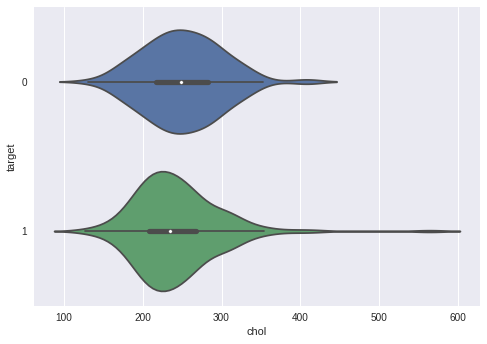

In [260]:
sns.violinplot(y=heart_csv['target'].astype('category'), x=heart_csv['chol'])

In [ ]:
# matriz de correlaciones 

corr_matrix = heart_csv.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

# Modelo 1 - Regresion Logistica

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# para las variables categoricas (no las binarias) necesitamos alguna manera de encodearlas
# one-hot encoding o dummy variables (ONE HOT NUNCA PARA ESTOS MODELOS PQ LA MATRIZ ES SINGULAR)

# corazon tonto 
dummy_heart = pd.get_dummies(heart_csv, columns=['cp', 'restecg', 'slope', 'ca', 'thal'], drop_first=True)

# split 70 / 30
X_train, X_test, y_train, y_test = train_test_split(dummy_heart.drop('target', axis=1), dummy_heart['target'], test_size = 0.3, random_state=23)


X_train.head(5)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_1,cp_2,...,restecg_2,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
163,38,1,138,175,0,173,0,0.0,0,1,...,0,0,1,0,0,0,1,0,1,0
260,66,0,178,228,1,165,1,1.0,0,0,...,0,1,0,0,1,0,0,0,0,1
124,39,0,94,199,0,179,0,0.0,0,1,...,0,0,1,0,0,0,0,0,1,0
110,64,0,180,325,0,154,1,0.0,0,0,...,0,0,1,0,0,0,0,0,1,0
13,64,1,110,211,0,144,1,1.8,0,0,...,0,1,0,0,0,0,0,0,1,0


In [53]:
# Veintitres

# primer modelo sin penalizacion  
# probaremos penalizacion l1 (| |), l2 (| |^2), elastic net (both of 'em)
lr = LogisticRegression(random_state=23, penalty='none', max_iter=1000, solver='newton-cg')

# la columna ca_4 hace que la convergencia del modelo sea pesima, la dropeamos momentaneamente (son todos 0's menos unos 5 1's)

#X_train = X_train.drop('ca_4', axis=1)
#X_test = X_test.drop('ca_4', axis=1)

# fiteamos la regresion logistica
lr.fit(X_train, y_train)

predicciones = lr.predict(X_test)


# el score en este caso es el accuracy (el loss es cross entropy...)
score = (predicciones == y_test).sum() / predicciones.size

print('Accuracy Regresion Logística: {}.\n'.format(score))

print(lr.coef_)

Accuracy Regresion Logística: 0.8351648351648352.

[[ 4.89143893e-02 -1.68680524e+00 -3.45581671e-02 -2.28955519e-03
   4.94311176e-01  2.03962731e-02 -9.68500949e-01 -2.29125358e-01
   9.95195973e-01  2.09849223e+00  2.27703030e+00  6.18115140e-01
  -8.01175856e-01 -7.17637787e-01  5.57686313e-01 -1.75552252e+00
  -3.41130920e+00 -2.65275937e+00  1.06783314e+01 -5.51177769e+00
  -5.04573697e+00 -6.64956243e+00]]


In [324]:
# quiero usar otra libreria que me de un poco mas de rigurosidad estadistica (aunque scikit-learn es muy buena para casi todo)

import statsmodels.api as sm

# la columna ca_4 hace que la convergencia del modelo sea pesima, la dropeamos momentaneamente (son todos 0's menos unos 5 1's)

#X_train = X_train.drop('ca_4', axis=1)
#X_test = X_test.drop('ca_4', axis=1)


logit_stats = sm.Logit(exog=np.asarray(X_train).astype('float'), endog=y_train).fit(maxiter = 1000, method='minimize')

Optimization terminated successfully.
         Current function value: 0.303475
         Iterations: 176
         Function evaluations: 180
         Gradient evaluations: 180


In [325]:
# ligeramente inferior al de scikit learn (pero tenemos un bello summary)
# falta agregar regularizacion!
probabilidades_estimadas = logit_stats.predict(np.asarray(X_test).astype('float'))

predicciones = list(map(round, probabilidades_estimadas))
acc = (predicciones == y_test).sum() / y_test.size

print('Accuracy Regresion Logística (statsmodels): {}.\n'.format(acc))
logit_stats.summary2()

Accuracy Regresion Logística (statsmodels): 0.8461538461538461.



<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.558     
Dependent Variable: target           AIC:              172.6734  
Date:               2021-02-27 18:27 BIC:              246.5183  
No. Observations:   212              Log-Likelihood:   -64.337   
Df Model:           21               LL-Null:          -145.59   
Df Residuals:       190              LLR p-value:      7.1801e-24
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     176.0000                                     
------------------------------------------------------------------
         Coef.    Std.Err.     z     P>|z|     [0.025      0.975] 
------------------------------------------------------------------
x1       0.0511     0.0306   1.6685  0.0952     -0.0089     0.1112
x2      -1.6861     0.7415  -2.2739  0.0230     -3.1393    -0.2328
x3      -0.0342     0.0137  -2.4981  0.0125     -0.0610    -0.0074
x4      -0.0022     0.0053  -0.4084  0.6830     -0.0126     0.0082
x5       0.4855     0.7128   0.6811  0.4958     -0.9116     1.8826
x6       0.0217     0.0155   1.3996  0.1616     -0.0087     0.0522
x7      -0.9623     0.5382  -1.7879  0.0738     -2.0173     0.0926
x8      -0.2226     0.2832  -0.7859  0.4319     -0.7777     0.3325
x9       0.9906     0.7172   1.3811  0.1673     -0.4152     2.3963
x10      2.1126     0.6265   3.3723  0.0007      0.8848     3.3404
x11      2.2840     0.8481   2.6930  0.0071      0.6217     3.9462
x12      0.6206     0.4900   1.2664  0.2054     -0.3398     1.5810
x13     -0.7956     3.0244  -0.2631  0.7925     -6.7234     5.1322
x14     -0.6844     0.9266  -0.7386  0.4602     -2.5005     1.1318
x15      0.6002     1.0126   0.5927  0.5534     -1.3845     2.5848
x16     -1.7586     0.6433  -2.7336  0.0063     -3.0195    -0.4977
x17     -3.4374     0.9183  -3.7431  0.0002     -5.2373    -1.6375
x18     -2.6632     1.1913  -2.2356  0.0254     -4.9981    -0.3284
x19     16.3237  3542.6348   0.0046  0.9963  -6927.1129  6959.7603
x20      0.7178     3.1739   0.2261  0.8211     -5.5030     6.9386
x21      1.1670     3.0840   0.3784  0.7051     -4.8776     7.2116
x22     -0.4403     3.1537  -0.1396  0.8890     -6.6214     5.7409
=================================================================

"""

# Regresion logistica con penalizacion 

In [14]:
# elastic net 
#C = k * 1/lambda
#C es inversamente proporcional a lambda
#recuerdo qeu si aumento lambda (disminuyo C) aumenta la regularizacion
max_acc = -1
best_c = -1
best_l1 = -1
lista_hp = []
cs = np.logspace(-1.5, 1, 5)
l1_ratios = np.linspace(0, 1, 100)
for l1 in l1_ratios:
    for c in cs:
        modelo = LogisticRegression(random_state=23, penalty='elasticnet', max_iter = 10000, solver = 'saga', l1_ratio = l1, C=c)
        modelo.fit(X_train, y_train)
        preds = modelo.predict(X_test)
        acc = np.mean(preds == y_test)
        if acc > max_acc:
            max_acc = acc
            best_c = c
            best_l1 = l1
        lista_hp.append((acc, c, 1))
        #print("Acc = {}, c = {}, l1 = {}".format(acc,c, l1))
        
print("Acc = {}, c = {}, l1 = {}".format(max_acc,best_c, best_l1))

# con este setup se consiguen los mejores resultados a partir de l1_ratio = 0 (solo penalizacion l2)
# c = 0.10979899497487436, acc = 83.51648351648352 % 
# literal converge a esa accuracy

Acc = 0.8791208791208791, c = 0.5623413251903491, l1 = 0.0
[(0.8351648351648352, 0.03162277660168379, 1), (0.8571428571428571, 0.1333521432163324, 1), (0.8791208791208791, 0.5623413251903491, 1), (0.8791208791208791, 2.371373705661655, 1), (0.8791208791208791, 10.0, 1), (0.8351648351648352, 0.03162277660168379, 1), (0.8571428571428571, 0.1333521432163324, 1), (0.8791208791208791, 0.5623413251903491, 1), (0.8791208791208791, 2.371373705661655, 1), (0.8791208791208791, 10.0, 1), (0.8351648351648352, 0.03162277660168379, 1), (0.8571428571428571, 0.1333521432163324, 1), (0.8791208791208791, 0.5623413251903491, 1), (0.8791208791208791, 2.371373705661655, 1), (0.8791208791208791, 10.0, 1), (0.8351648351648352, 0.03162277660168379, 1), (0.8571428571428571, 0.1333521432163324, 1), (0.8791208791208791, 0.5623413251903491, 1), (0.8791208791208791, 2.371373705661655, 1), (0.8791208791208791, 10.0, 1), (0.8351648351648352, 0.03162277660168379, 1), (0.8571428571428571, 0.1333521432163324, 1), (0.87

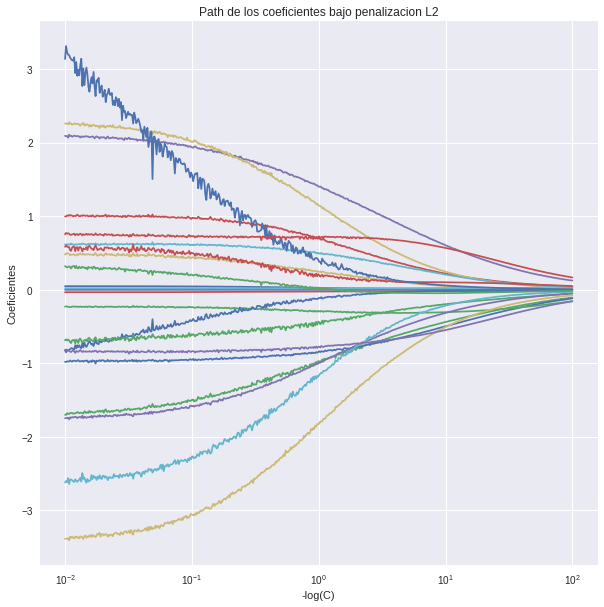

0.8901098901098901


In [51]:
# regularizacion l2
# por default tiene regularizacion l2
cs = np.logspace(-2, 2, 500)
model_coefs = []
max_acc = -1
best_c = -1
best_model = None
for c in cs:
    modelo_l2 = LogisticRegression(random_state = 23, penalty='l2', max_iter = 5000, C=c)
    modelo_l2.fit(X_train, y_train)
    preds = modelo_l2.predict(X_test)
    acc = np.mean(preds == y_test)
    if max_acc < acc:
        max_acc = acc
        best_c = c
        best_model = modelo_l2
    model_coefs.append(modelo_l2.coef_.ravel().copy())
    
cs = np.array(list(map(lambda x: 1/(x), cs)))
model_coefs = np.array(model_coefs)


plt.figure(figsize=(10,10))
ax = plt.gca()

ax.plot(cs, model_coefs)
ax.set_xscale('log')

plt.xlabel('-log(C)')
plt.ylabel('Coeficientes')
plt.title('Path de los coeficientes bajo penalizacion L2')
plt.axis('tight')

plt.show()

print(max_acc)

In [52]:
coefs_l2 = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(best_model.coef_))], axis = 1)
coefs_l2

,0,0
0,age,0.000562
1,sex,-0.334189
2,trestbps,-0.018434
3,chol,-0.001380
4,fbs,0.023916
5,thalach,0.022905
6,exang,-0.379860
7,oldpeak,-0.286817
8,cp_1,0.147744
9,cp_2,0.435274


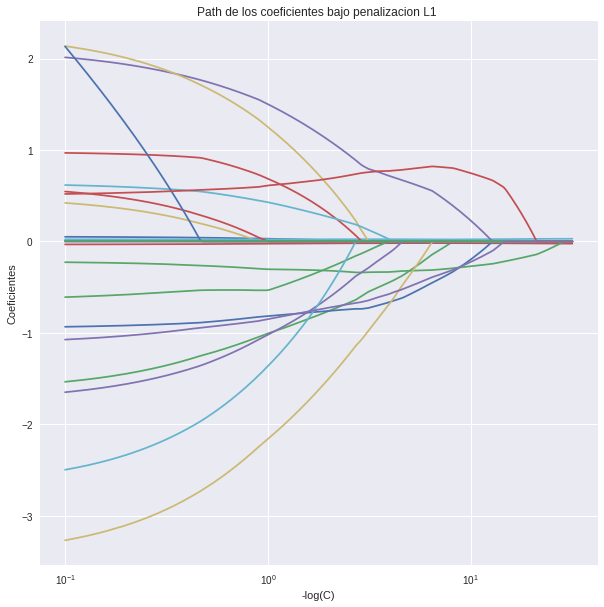

0.9010989010989011 1.3987131026472386


In [24]:
# regularizacion l1
# liblinear es bueno para sets chiquitos y funciona con l1 
# mejor modelo hasta ahora

cs = np.logspace(-1.5, 1, 200)
model_coefs = []
max_acc = -1
best_c = -1
best_model = None
for c in cs:
    modelo_l1 = LogisticRegression(random_state = 23, penalty='l1', max_iter = 100, solver = 'liblinear', C=c)
    modelo_l1.fit(X_train, y_train)
    preds = modelo_l1.predict(X_test)
    acc = np.mean(preds == y_test)
    if max_acc < acc:
        max_acc = acc
        best_c = c
        best_model = modelo_l1
    model_coefs.append(modelo_l1.coef_.ravel().copy())

cs = np.array(list(map(lambda x: 1/(x), cs)))
model_coefs = np.array(model_coefs)


plt.figure(figsize=(10,10))
ax = plt.gca()

ax.plot(cs, model_coefs)
ax.set_xscale('log')

plt.xlabel('-log(C)')
plt.ylabel('Coeficientes')
plt.title('Path de los coeficientes bajo penalizacion L1 ')
plt.axis('tight')

plt.show()

print(max_acc, best_c)

In [25]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(best_model.coef_))], axis = 1)

In [50]:
# vemos que l1 mata a ca_4 (la que introduce problemas en la convergencia del modelo)
# mata tambien a thal_1 (tambien introduce problemas)
# idem restecg_2


,0,0
0,age,0.035579
1,sex,-1.124004
2,trestbps,-0.026853
3,chol,-0.001608
4,fbs,0.079312
5,thalach,0.022784
6,exang,-0.849305
7,oldpeak,-0.283893
8,cp_1,0.805349
9,cp_2,1.634487
